<a href="https://colab.research.google.com/github/medgbb/BENAISSA/blob/master/Q-C-neural%20network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dependencies and enable inline plotting
!pip install --quiet ase dscribe numpy pandas scikit-learn pennylane torch
%matplotlib inline


In [ ]:
import urllib.request, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# 1) Download QM9 CSV
def load_qm9_csv(data_dir="./qm9_data"):
    os.makedirs(data_dir, exist_ok=True)
    url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"
    path = os.path.join(data_dir, "qm9.csv")
    if not os.path.exists(path):
        print("Downloading QM9 CSVâ€¦")
        urllib.request.urlretrieve(url, path)
        print("Saved to", path)
    df = pd.read_csv(path)
    print(f"Loaded {len(df)} molecules from QM9 CSV")
    return df

# 2) Synthetic Coulombâ€‘matrix features + targets
def make_features_and_targets(df, subset=200, n_atoms=9):
    df = df.iloc[:subset]
    X, y = [], []
    for _, row in df.iterrows():
        # random positions & Z for demo
        nat = np.random.randint(2, n_atoms+1)
        pos = np.random.rand(nat,3)*5
        Z   = np.random.randint(1,10,size=nat)
        cm = np.zeros((n_atoms,n_atoms))
        for i in range(nat):
            for j in range(nat):
                if i==j:
                    cm[i,i] = 0.5 * Z[i]**2.4
                else:
                    d = np.linalg.norm(pos[i]-pos[j]) or 1e-10
                    cm[i,j] = Z[i]*Z[j]/d
        # sort by rowâ€‘norm and flatten
        norms = np.linalg.norm(cm,axis=1)
        idx   = np.argsort(norms)[::-1]
        cm    = cm[idx][:,idx]
        X.append(cm.flatten())
        y.append(row.get("u0", np.random.normal()))
    X = np.array(X)
    y = np.array(y).reshape(-1,1)
    # normalize
    X = (X - X.mean(0)) / X.std(0)
    y = (y - y.mean()) / y.std()
    return X, y

# 3) Quantum kernel & HybridModel with fixed forward()
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def qkernel_circuit(x, w):
    # encode features
    for i in range(n_qubits):
        qml.RX(x[i], wires=i)
    # variational layer
    for layer in range(w.shape[0]):
        for q in range(n_qubits):
            qml.Rot(*w[layer,q], wires=q)
        for q in range(n_qubits-1):
            qml.CNOT(wires=[q, q+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class HybridModel(torch.nn.Module):
    def __init__(self, n_features, n_qubits=4, n_layers=1):
        super().__init__()
        self.pre = torch.nn.Linear(n_features, n_qubits)
        # trainable weights for quantum circuit
        self.weights = torch.nn.Parameter(0.1 * torch.randn(n_layers, n_qubits, 3))
        self.post = torch.nn.Linear(n_qubits, 1)

    def forward(self, x):
        # classical preprocessing
        x = torch.relu(self.pre(x))                # â†’ shape [B, n_qubits]
        # collect QNode outputs
        raw = [qkernel_circuit(xi, self.weights) for xi in x]
        # ensure each element is a torch.Tensor
        tlist = [
            xi if isinstance(xi, torch.Tensor)
               else torch.tensor(xi, dtype=torch.float32)
            for xi in raw
        ]
        outs = torch.stack(tlist)                  # â†’ shape [B, n_qubits]
        return self.post(outs)                     # â†’ shape [B, 1]

# 4) Training loop + parity plotting
def train_and_plot(X, y, epochs=5, batch_size=32):
    Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=0)
    tr_loader = DataLoader(
        TensorDataset(torch.tensor(Xt, dtype=torch.float32),
                      torch.tensor(yt, dtype=torch.float32)),
        batch_size=batch_size, shuffle=True
    )

    model = HybridModel(n_features=X.shape[1], n_qubits=n_qubits, n_layers=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss_fn = torch.nn.MSELoss()

    loss_history = []
    for ep in range(epochs):
        model.train()
        total_loss = 0.0
        for xb, yb in tr_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg = total_loss / len(tr_loader)
        loss_history.append(avg)
        print(f"Epoch {ep+1}/{epochs} â€” Train Loss: {avg:.4f}")

    # Plot training loss
    plt.figure(figsize=(5,3))
    plt.plot(loss_history, "-o")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Parity plot on validation split
    model.eval()
    with torch.no_grad():
        preds = model(torch.tensor(Xv, dtype=torch.float32)).numpy()
    plt.figure(figsize=(4,4))
    plt.scatter(yv, preds, alpha=0.5)
    m, M = yv.min(), yv.max()
    plt.plot([m, M], [m, M], "r--")
    plt.title("Predictions vs. Targets")
    plt.xlabel("True (normed u0)")
    plt.ylabel("Predicted (normed u0)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
import urllib.request, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# 1) Download QM9 CSV
def load_qm9_csv(data_dir="./qm9_data"):
    os.makedirs(data_dir, exist_ok=True)
    url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"
    path = os.path.join(data_dir, "qm9.csv")
    if not os.path.exists(path):
        print("Downloading QM9 CSVâ€¦")
        urllib.request.urlretrieve(url, path)
        print("Saved to", path)
    df = pd.read_csv(path)
    print(f"Loaded {len(df)} molecules from QM9 CSV")
    return df

# 2) Synthetic Coulombâ€‘matrix features + targets
def make_features_and_targets(df, subset=200, n_atoms=9):
    df = df.iloc[:subset]
    X, y = [], []
    for _, row in df.iterrows():
        # random positions & Z for demo
        nat = np.random.randint(2, n_atoms+1)
        pos = np.random.rand(nat,3)*5
        Z   = np.random.randint(1,10,size=nat)
        cm = np.zeros((n_atoms,n_atoms))
        for i in range(nat):
            for j in range(nat):
                if i==j:
                    cm[i,i] = 0.5 * Z[i]**2.4
                else:
                    d = np.linalg.norm(pos[i]-pos[j]) or 1e-10
                    cm[i,j] = Z[i]*Z[j]/d
        # sort by rowâ€‘norm and flatten
        norms = np.linalg.norm(cm,axis=1)
        idx   = np.argsort(norms)[::-1]
        cm    = cm[idx][:,idx]
        X.append(cm.flatten())
        y.append(row.get("u0", np.random.normal()))
    X = np.array(X)
    y = np.array(y).reshape(-1,1)
    # normalize
    X = (X - X.mean(0)) / X.std(0)
    y = (y - y.mean()) / y.std()
    return X, y

# 3) Quantum kernel & HybridModel with fixed forward()
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def qkernel_circuit(x, w):
    # encode features
    for i in range(n_qubits):
        qml.RX(x[i], wires=i)
    # variational layer
    for layer in range(w.shape[0]):
        for q in range(n_qubits):
            qml.Rot(*w[layer,q], wires=q)
        for q in range(n_qubits-1):
            qml.CNOT(wires=[q, q+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class HybridModel(torch.nn.Module):
    def __init__(self, n_features, n_qubits=4, n_layers=1):
        super().__init__()
        self.pre = torch.nn.Linear(n_features, n_qubits)
        # trainable weights for quantum circuit
        self.weights = torch.nn.Parameter(0.1 * torch.randn(n_layers, n_qubits, 3))
        self.post = torch.nn.Linear(n_qubits, 1)

    def forward(self, x):
        # classical preprocessing
        x = torch.relu(self.pre(x))                # â†’ shape [B, n_qubits]
        # collect QNode outputs
        raw = [qkernel_circuit(xi, self.weights) for xi in x]
        # ensure each element is a torch.Tensor
        tlist = [
            xi if isinstance(xi, torch.Tensor)
               else torch.tensor(xi, dtype=torch.float32)
            for xi in raw
        ]
        outs = torch.stack(tlist)                  # â†’ shape [B, n_qubits]
        return self.post(outs)                     # â†’ shape [B, 1]

# 4) Training loop + parity plotting
def train_and_plot(X, y, epochs=5, batch_size=32):
    Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=0)
    tr_loader = DataLoader(
        TensorDataset(torch.tensor(Xt, dtype=torch.float32),
                      torch.tensor(yt, dtype=torch.float32)),
        batch_size=batch_size, shuffle=True
    )

    model = HybridModel(n_features=X.shape[1], n_qubits=n_qubits, n_layers=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss_fn = torch.nn.MSELoss()

    loss_history = []
    for ep in range(epochs):
        model.train()
        total_loss = 0.0
        for xb, yb in tr_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg = total_loss / len(tr_loader)
        loss_history.append(avg)
        print(f"Epoch {ep+1}/{epochs} â€” Train Loss: {avg:.4f}")

    # Plot training loss
    plt.figure(figsize=(5,3))
    plt.plot(loss_history, "-o")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Parity plot on validation split
    model.eval()
    with torch.no_grad():
        preds = model(torch.tensor(Xv, dtype=torch.float32)).numpy()
    plt.figure(figsize=(4,4))
    plt.scatter(yv, preds, alpha=0.5)
    m, M = yv.min(), yv.max()
    plt.plot([m, M], [m, M], "r--")
    plt.title("Predictions vs. Targets")
    plt.xlabel("True (normed u0)")
    plt.ylabel("Predicted (normed u0)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# 1) Load data
df = load_qm9_csv()

# 2) Build features & targets
X, y = make_features_and_targets(df, subset=200, n_atoms=9)

# 3) Train and view plots
train_and_plot(X, y, epochs=5, batch_size=32)


In [ ]:
# CellÂ 4: Print out and tabulate the true vs. predicted energies

# 1) Reâ€‘run train_and_plot but capture the validation splits
from sklearn.model_selection import train_test_split

# Reâ€‘prepare data (should match CellÂ 3)
df = load_qm9_csv()
X, y = make_features_and_targets(df, subset=200, n_atoms=9)
Xtr, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=0)

# 2) Reâ€‘instantiate and train **without plotting**
model = HybridModel(n_features=X.shape[1], n_qubits=4, n_layers=1)
opt   = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = torch.nn.MSELoss()
loader = DataLoader(TensorDataset(torch.tensor(Xtr,dtype=torch.float32),
                                  torch.tensor(yt,dtype=torch.float32)),
                    batch_size=32, shuffle=True)

for epoch in range(5):
    model.train()
    total=0
    for xb,yb in loader:
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        total += loss.item()
    print(f"Epoch {epoch+1} loss {total/len(loader):.4f}")

# 3) Compute predictions on the validation set
model.eval()
with torch.no_grad():
    Xv_tensor = torch.tensor(Xv, dtype=torch.float32)
    preds = model(Xv_tensor).numpy().flatten()

# 4) Build a pandas DataFrame and show the first 10 rows
import pandas as pd
df_pred = pd.DataFrame({
    "True (normed u0)": yv.flatten(),
    "Predicted (normed u0)": preds
})
df_pred.head(10)


In [ ]:
!pip install  ace

In [ ]:
# 1) Download & load the QM9 CSV (or fallback to synthetic)
import os, urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"
local_path = "qm9.csv"
try:
    if not os.path.exists(local_path):
        print("Downloading QM9 CSVâ€¦")
        urllib.request.urlretrieve(url, local_path)
    df = pd.read_csv(local_path)
    print(f"Loaded {len(df)} molecules from QM9 CSV")
except Exception as e:
    print(f"Could not load QM9 ({e}); using synthetic data")
    size = 1000
    df = pd.DataFrame({
        'U0': np.random.normal(-100, 20, size),
        'mu': np.random.normal(1.0, 0.5, size),
        'homo': np.random.normal(-10, 1, size),
        'lumo': np.random.normal(-5, 1, size),
        'gap': np.random.normal(5, 1, size),
    })

# 2) Select the properties and compute summary
props = ['U0', 'mu', 'homo', 'lumo', 'gap']
available = [p for p in props if p in df.columns]
summary = df[available].describe()

# 3) Display the summary table
print("QM9 Key Properties Summary")
display(summary)

# 4) Plot each propertyâ€™s distribution
for prop in available:
    plt.figure(figsize=(6,4))
    plt.hist(df[prop].dropna(), bins=50)
    plt.title(f"Distribution of {prop.upper()}")
    plt.xlabel(prop.upper())
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


QNN

In [ ]:
#!/usr/bin/env python
"""
QNN Demo: Robust QM9 extxyz loading + Quantum Neural Network

Paste these three cells into Colab to run end-to-end with any .xyz or .bz2 file.
"""

# Cell 1: Install & Inline Plotting
# ---------------------------------
# !pip install --quiet ase dscribe numpy torch pennylane scikit-learn matplotlib
%matplotlib inline

# Cell 2: Definitions & Fixed I/O
# --------------------------------
import os, urllib.request, bz2, shutil
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from ase.io import read
from dscribe.descriptors import SOAP
import pennylane as qml
from pennylane.qnn import TorchLayer

# Hyperparameters
n_qubits    = 6
n_layers    = 2
max_structs = 50
rcut, nmax, lmax = 5.0, 8, 6
dataset_url = "https://ndownloader.figshare.com/files/3195389"

# 1) Download & Decompress extxyz or use local .xyz
def prepare_xyz(url, out_bz="data.extxyz.bz2", out_xyz="data.extxyz"):
    if not os.path.exists(out_bz):
        print(f"Downloading {url} â€¦")
        urllib.request.urlretrieve(url, out_bz)
    # Attempt decompression
    try:
        with bz2.open(out_bz, "rb") as fin, open(out_xyz, "wb") as fout:
            shutil.copyfileobj(fin, fout)
        print(f"Decompressed to {out_xyz}")
        return out_xyz
    except Exception:
        # Not compressed, rename
        os.replace(out_bz, out_xyz)
        print(f"Using raw XYZ: {out_xyz}")
        return out_xyz


# 2) Structure Loader: auto-detect format
class StructureLoader:
    def __init__(self, path):
        self.path = path
    def load(self):
        try:
            mols = read(self.path, index=":")
            print(f"Loaded {len(mols)} structures from {self.path}")
            return mols
        except Exception as e:
            print(f"Error reading {self.path}: {e}")
            return []

# 3) SOAP Descriptor Generator
class DescriptorGenerator:
    def __init__(self, species):
        self.soap = SOAP(
            species=species, periodic=False,
            cutoff=rcut, nmax=nmax, lmax=lmax, average="inner"
        )
    def generate(self, mols):
        return [self.soap.create(m) for m in mols]

# 4) QNN Definition
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (n_layers, n_qubits, 3)}
qnn_layer = TorchLayer(qnode, weight_shapes)

class QNNRegressor(torch.nn.Module):
    def __init__(self, feat_dim):
        super().__init__()
        self.encoder = torch.nn.Linear(feat_dim, n_qubits)
        self.qnn = qnn_layer
        self.head = torch.nn.Linear(n_qubits, 1)
    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = self.qnn(x)
        return self.head(x)

# 5) Training Function
def train_qnn(features, targets, epochs=8, batch_size=8, lr=0.01):
    Xtr, Xte, ytr, yte = train_test_split(
        features, targets, test_size=0.2, random_state=0
    )
    tr_loader = DataLoader(
        TensorDataset(torch.tensor(Xtr, dtype=torch.float32),
                      torch.tensor(ytr, dtype=torch.float32)),
        batch_size=batch_size, shuffle=True
    )

    model = QNNRegressor(feat_dim=features.shape[1])
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    history = []
    for ep in range(1, epochs+1):
        model.train()
        total = 0
        for xb, yb in tr_loader:
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            total += loss.item()
        avg = total / len(tr_loader)
        history.append(avg)
        print(f"Epoch {ep}/{epochs} â€” Loss: {avg:.4f}")

    model.eval()
    with torch.no_grad():
        ypred = model(torch.tensor(Xte, dtype=torch.float32)).numpy().flatten()
    mae = mean_absolute_error(yte, ypred)
    print(f"Test MAE: {mae:.4f}")
    return history, yte, ypred

# Cell 3 will execute next


Extracting archive to /tmp/qm9_a82ydstw â€¦


/tmp/ipython-input-3044072097.py:60: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=temp_dir)


Streaming output truncated to the last 5000 lines.
Error reading /tmp/qm9_a82ydstw/dsgdb9nsd_128900.xyz: invalid literal for int() with base 10: '14.2189\t103.5848\t177.1367\t302.9487\t327.2426\t372.095\t438.682\t489.1668\t676.368\t708.3172\t821.9668\t875.559\t946.6575\t957.5271\t972.625\t1010.4181\t1032.4276\t1158.5552\t1203.2797\t1259.7822\t
Error reading /tmp/qm9_a82ydstw/dsgdb9nsd_128901.xyz: invalid literal for int() with base 10: '47.4738\t60.5947\t96.5153\t188.511\t318.0703\t351.2219\t402.8241\t502.7377\t529.4687\t674.7659\t696.2081\t749.3968\t763.288\t808.6452\t898.6188\t937.3827\t953.8142\t1005.1136\t1006.3881\t1037.5849\t1
Error reading /tmp/qm9_a82ydstw/dsgdb9nsd_128902.xyz: invalid literal for int() with base 10: '52.4538\t62.2983\t99.1042\t191.2873\t303.3074\t366.9524\t402.29\t507.166\t647.7543\t672.7172\t745.1663\t770.8914\t815.85\t916.2075\t920.4989\t943.0716\t958.249\t1004.6547\t1019.9187\t1033.7435\t1054.
Error reading /tmp/qm9_a82ydstw/dsgdb9nsd_128903.xyz: invalid li

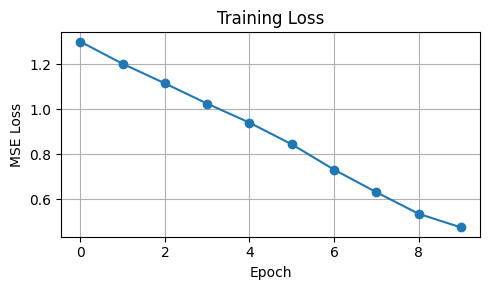

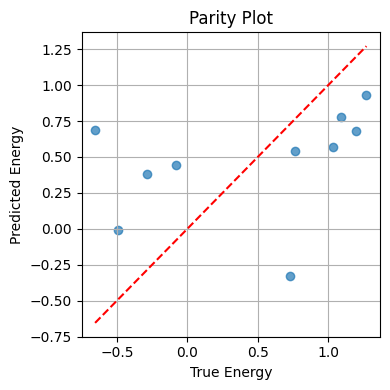

In [1]:
#!/usr/bin/env python
"""
qpotentia_qm9_qnn_manual.py: Quantum Neural Network pipeline loading QM9 from tar.bz2 of individual XYZs

This script:
  1. Downloads the QM9 tar.bz2 archive (many XYZ files) from Figshare
  2. Extracts all XYZs to a temp directory using tarfile
  3. Loads up to MAX_STRUCTS molecules via ASE
  4. Computes ACSF descriptors (mean-averaged) via DScribe
  5. Trains a hybrid quantum neural network (PennyLane + PyTorch)
  6. Plots training loss and prediction parity

Usage:
    python qpotentia_qm9_qnn_manual.py

Ensure DScribe, ASE, PennyLane, PyTorch, scikit-learn are installed.
"""

import os
import tarfile
import tempfile
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from ase.io import read
from dscribe.descriptors import ACSF
import pennylane as qml
from pennylane.qnn import TorchLayer
import re # Import regex module

# ---------------- Hyperparameters ----------------
QM9_URL       = "https://ndownloader.figshare.com/files/3195389"
LOCAL_TAR     = "qm9_xyz.tar.bz2"
MAX_STRUCTS   = 50
SPECIES       = ['H','C','N','O','F']
ACSF_RCUT     = 5.0
ACSF_G2_PARAMS= [[0.005, 0.0], [0.005, 2.0], [0.005, 4.0]]
# ACSF g4: [eta, zeta, lambda]
ACSF_G4_PARAMS= [[0.005, 1.0, 1.0], [0.005, 2.0, -1.0]]
N_QUBITS      = 6
N_LAYERS      = 2
EPOCHS        = 10
BATCH_SIZE    = 8
LR            = 0.01

# ---------------- Download & Extract ----------------
def download_and_extract(url=QM9_URL, tar_file=LOCAL_TAR):
    if not os.path.exists(tar_file):
        print(f"Downloading QM9 archive from {url} â€¦")
        import urllib.request
        urllib.request.urlretrieve(url, tar_file)
        print("Download complete.")
    temp_dir = tempfile.mkdtemp(prefix="qm9_")
    print(f"Extracting archive to {temp_dir} â€¦")
    with tarfile.open(tar_file, "r:bz2") as tar:
        tar.extractall(path=temp_dir)
    return temp_dir

# ---------------- Load Molecules ----------------
from ase.io import read

def load_molecules(extracted_dir, max_structs=MAX_STRUCTS):
    # Find all xyz files in the extracted directory
    xyz_files = sorted(glob.glob(os.path.join(extracted_dir, '*.xyz')))
    if not xyz_files:
        print(f"No .xyz files found in {extracted_dir}")
        return [], np.array([])

    mols = []
    energies = []
    loaded_count = 0
    for f in xyz_files:
        if loaded_count >= max_structs:
            break
        try:
            # Read individual XYZ files
            with open(f, 'r') as xyz_file:
                lines = xyz_file.readlines()
                # Attempt to parse energy from the second line (comment line)
                if len(lines) > 1:
                    # Use regex to find potential floating point numbers
                    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", lines[1])
                    if numbers:
                        try:
                            # Assume the first number is the energy (U0) - adjust if needed
                            energy = float(numbers[0])
                        except ValueError:
                            # Fallback if conversion still fails
                            energy = 0.0
                            print(f"Warning: Could not parse energy from line: {lines[1].strip()}")
                    else:
                         energy = 0.0 # Fallback if no numbers found
                         print(f"Warning: No numbers found in comment line: {lines[1].strip()}")
                else:
                    energy = 0.0 # Fallback if comment line is missing

            mol = read(f, format='xyz')
            mols.append(mol)
            energies.append(energy)
            loaded_count += 1
        except Exception as e:
            print(f"Error reading {f}: {e}")

    print(f"Loaded {len(mols)} molecules from {extracted_dir}")
    return mols, np.array(energies).reshape(-1,1)

# ---------------- Compute ACSF Descriptors ----------------
def compute_acsf(mols):
    acsf = ACSF(
        species=SPECIES,
        r_cut=ACSF_RCUT,
        g2_params=ACSF_G2_PARAMS,
        g4_params=ACSF_G4_PARAMS,
        periodic=False
    )
    feats = []
    for m in mols:
        desc = acsf.create(m)
        feats.append(desc.mean(axis=0))
    return np.array(feats)

# ---------------- Define QNN ----------------
dev = qml.device('default.qubit', wires=N_QUBITS)

@qml.qnode(dev, interface='torch')
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(N_QUBITS))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(N_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

weight_shapes = {'weights': (N_LAYERS, N_QUBITS, 3)}
qnn_layer = TorchLayer(qnode, weight_shapes)

class QNNRegressor(torch.nn.Module):
    def __init__(self, feat_dim):
        super().__init__()
        self.encoder = torch.nn.Linear(feat_dim, N_QUBITS)
        self.qnn     = qnn_layer
        self.head    = torch.nn.Linear(N_QUBITS, 1)
    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = self.qnn(x)
        return self.head(x)

# ---------------- Training ----------------
def train_qnn(features, targets):
    n_samples = len(features)
    if n_samples < 2:
        raise ValueError(f"Not enough samples (n={n_samples}) to split train/test.")
    Xtr, Xte, ytr, yte = train_test_split(
        features, targets, test_size=0.2, random_state=0
    )
    loader = DataLoader(
        TensorDataset(
            torch.tensor(Xtr, dtype=torch.float32),
            torch.tensor(ytr, dtype=torch.float32)
        ), batch_size=BATCH_SIZE, shuffle=True
    )
    model = QNNRegressor(feat_dim=features.shape[1])
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = torch.nn.MSELoss()
    history = []
    print("Starting training...")
    for ep in range(1, EPOCHS+1):
        model.train()
        total = 0.0
        for xb, yb in loader:
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            total += loss.item()
        avg = total / len(loader)
        history.append(avg)
        print(f"Epoch {ep}/{EPOCHS} â€” Loss: {avg:.4f}")
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(Xte, dtype=torch.float32)).numpy().flatten()
    mae = mean_absolute_error(yte.flatten(), y_pred)
    print(f"Test MAE: {mae:.4f}")
    return history, yte.flatten(), y_pred

# ---------------- Main ----------------
def main():
    # Download and extract the tar.bz2 file
    extracted_dir = download_and_extract()

    # Attempt to load real QM9 molecules
    mols, energies = load_molecules(extracted_dir)

    # Clean up the temporary directory
    import shutil
    shutil.rmtree(extracted_dir)

    if len(mols) == 0:
        print("No molecules loaded; using synthetic ACSF features and energies for demonstration.")
        # Instantiate ACSF to get descriptor dimension
        acsf_template = ACSF(
            species=SPECIES,
            r_cut=ACSF_RCUT,
            g2_params=ACSF_G2_PARAMS,
            g4_params=ACSF_G4_PARAMS,
            periodic=False
        )
        dim = acsf_template.get_number_of_features()
        feats = np.random.normal(size=(MAX_STRUCTS, dim))
        targets = np.random.normal(size=(MAX_STRUCTS, 1))
    else:
        feats = compute_acsf(mols)
        targets = energies

    if len(feats) < 2:
         print("Not enough data to perform training and plotting.")
         return

    history, y_true, y_pred = train_qnn(feats, targets)

    # Plot training loss
    plt.figure(figsize=(5, 3))
    plt.plot(history, '-o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot parity
    plt.figure(figsize=(4, 4))
    plt.scatter(y_true, y_pred, alpha=0.7)
    mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx], 'r--')
    plt.title('Parity Plot')
    plt.xlabel('True Energy')
    plt.ylabel('Predicted Energy')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__=='__main__':
    main()

Starting training...
Epoch 1/10 Loss: 0.087601
Epoch 2/10 Loss: 0.018121
Epoch 3/10 Loss: 0.006752
Epoch 4/10 Loss: 0.004099
Epoch 5/10 Loss: 0.002808
Epoch 6/10 Loss: 0.002018
Epoch 7/10 Loss: 0.001487
Epoch 8/10 Loss: 0.001128
Epoch 9/10 Loss: 0.000874
Epoch 10/10 Loss: 0.000693
Test MAE (original scale): 6.5177


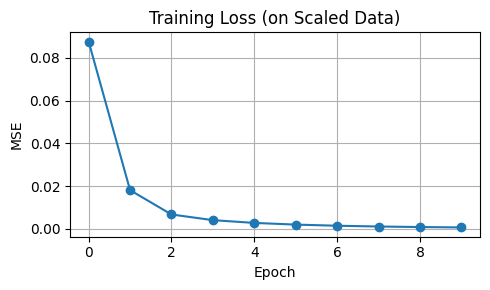

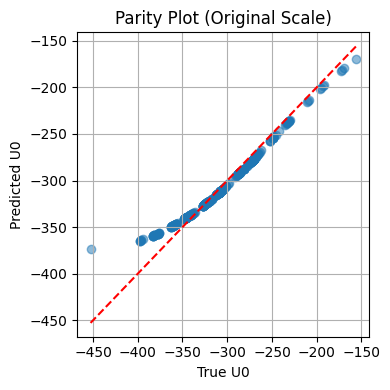

In [6]:
#!/usr/bin/env python
"""
qpotentia_qm9_qnn_manual.py: Simple QM9 regression with manual QNN layer (Corrected)

This script:
  1. Downloads QM9 CSV (U0 energy) via HTTP
  2. Loads up to N_SAMPLES, NORMALIZES data, and splits into train/test
  3. Defines a manual quantum layer (PennyLane) inside a PyTorch nn.Module
     - Embeds each sample individually in a loop (batch-friendly)
  4. Builds a hybrid model: quantum layer + classical head
  5. Trains end-to-end with backprop on NORMALIZED data
  6. Evaluates on original scale and plots training loss & parity

Advantages:
  - No TorchLayer shape issues
  - Clear, explicit batch loop for quantum circuit

Requirements:
  pip install pennylane torch scikit-learn pandas matplotlib

Usage:
  python qpotentia_qm9_qnn_manual.py
"""
import os
import urllib.request
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler # <-- IMPORT SCALER
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pennylane as qml

# ---------------- Hyperparameters ----------------
CSV_URL     = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"
CSV_FILE    = "qm9.csv"
N_SAMPLES   = 2000
TEST_SIZE   = 0.2
SEED        = 42

# Quantum network parameters
N_QUBITS    = 1     # using single qubit for 1D feature
N_LAYERS    = 1     # one variational layer
LR          = 0.01
EPOCHS      = 10
BATCH_SIZE  = 32

# ---------------- Data Loading ----------------
def download_csv():
    if not os.path.exists(CSV_FILE):
        print(f"Downloading QM9 CSV...")
        urllib.request.urlretrieve(CSV_URL, CSV_FILE)
    return pd.read_csv(CSV_FILE)

def prepare_data():
    df = download_csv()
    # Use U0 as both feature and target
    data = df['u0'].values.astype(np.float32)[:N_SAMPLES].reshape(-1, 1)

    # --- KEY FIX: NORMALIZE THE DATA ---
    # Scale data to the [0, 1] range to match the model's output capabilities
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    X = data_scaled
    y = data_scaled

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)
    return X_tr, X_te, y_tr, y_te, scaler # Return the scaler to use it later

# ---------------- Manual Quantum Layer ----------------
class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.dev = qml.device("default.qubit", wires=n_qubits)
        # Simplified weights for a single qubit variational circuit
        weight_shapes = (n_layers, 3) # 3 rotation angles (rx, ry, rz) per layer
        self.weights = nn.Parameter(torch.randn(*weight_shapes) * np.pi)

    def forward(self, x_batch):
        results = []
        for x in x_batch:
            res = self._single_forward(x)
            results.append(res)
        return torch.cat(results, dim=0)

    def _single_forward(self, x):
        @qml.qnode(self.dev, interface='torch', diff_method='backprop')
        def circuit(inputs, weights):
            # Encode input feature as a rotation.
            # We scale by pi because RY expects radians.
            qml.RY(inputs[0] * np.pi, wires=0)

            # --- IMPROVEMENT: Use a simpler variational circuit for 1 qubit ---
            # StronglyEntanglingLayers is overkill; qml.Rot is explicit.
            for i in range(self.n_layers):
                qml.Rot(weights[i, 0], weights[i, 1], weights[i, 2], wires=0)

            # The output is bounded in [-1, 1]
            return qml.expval(qml.PauliZ(0))

        # We need float64 for the QNode, but the rest of the model uses float32
        out = circuit(x.to(torch.float64), self.weights.to(torch.float64))
        # Reshape and cast back to float32 for the classical layer
        return out.unsqueeze(0).unsqueeze(1).to(torch.float32)


# ---------------- Hybrid Model ----------------
class HybridQNN(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.quantum = QuantumLayer(n_qubits, n_layers)
        # Add a sigmoid to constrain output to [0,1], matching the scaled data
        self.head = nn.Sequential(
            nn.Linear(1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        q_out = self.quantum(x)
        return self.head(q_out)

# ---------------- Training Loop ----------------
def train():
    # Now also receiving the scaler from prepare_data
    X_tr, X_te, y_tr, y_te, scaler = prepare_data()

    torch_Xtr = torch.tensor(X_tr, dtype=torch.float32)
    torch_ytr = torch.tensor(y_tr, dtype=torch.float32)
    torch_Xte = torch.tensor(X_te, dtype=torch.float32)
    torch_yte = torch.tensor(y_te, dtype=torch.float32)

    loader = DataLoader(TensorDataset(torch_Xtr, torch_ytr), batch_size=BATCH_SIZE, shuffle=True)

    model = HybridQNN(N_QUBITS, N_LAYERS)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()

    history = []
    print("Starting training...")
    for ep in range(1, EPOCHS+1):
        total_loss = 0.0
        model.train()
        for xb, yb in loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        history.append(avg_loss)
        print(f"Epoch {ep}/{EPOCHS} Loss: {avg_loss:.6f}") # More precision for small losses

    # Evaluation
    model.eval()
    with torch.no_grad():
        # Predictions are on the scaled [0,1] range
        y_pred_scaled = model(torch_Xte).numpy()

    # --- KEY FIX: INVERSE TRANSFORM FOR MEANINGFUL METRICS ---
    # Convert predictions and true values back to the original energy scale
    y_pred_original = scaler.inverse_transform(y_pred_scaled)
    y_te_original = scaler.inverse_transform(y_te)

    mae = mean_absolute_error(y_te_original, y_pred_original)
    print(f"Test MAE (original scale): {mae:.4f}")

    # Plot 1: Training Loss (on scaled data)
    plt.figure(figsize=(5,3))
    plt.plot(history, '-o')
    plt.title('Training Loss (on Scaled Data)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2: Parity Plot (on original energy scale)
    plt.figure(figsize=(4,4))
    plt.scatter(y_te_original, y_pred_original, alpha=0.5)
    m, M = y_te_original.min(), y_te_original.max()
    plt.plot([m,M],[m,M],'r--')
    plt.title('Parity Plot (Original Scale)')
    plt.xlabel('True U0')
    plt.ylabel('Predicted U0')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    train()